In [1]:
from final_model_log_scale import MtoF, WAE, AudioDataset
import torch
import numpy as np
import matplotlib.pyplot as plt
from time import time
import librosa as li
from IPython.display import Audio
from util import audio_utilities as au

In [2]:
model = WAE(3,128)

In [3]:
def get_oct_semi(f0):
    f = 27.5*2**(np.arange(84)/12)
    idx = np.argmin(abs(f-f0))
    octave = torch.zeros([7])
    semi   = torch.zeros([12])
    octave[idx//12] = 1
    semi[idx%12] = 1
    return octave.unsqueeze(0) ,semi.unsqueeze(0)

In [4]:
torch.nn.Module.dump_patches = True

model,log = torch.load("../guitare_motu_500_e.pt", map_location="cpu")
model.eval()

motu = AudioDataset("/home/antoine/Musique/enregistrement_cordes/export/motu_dataset/*.wav", slice_size=128, process=0)

print("Done!")

Done!


/home/antoine/ml/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'final_model_log_scale.WAE' has changed. Tried to save a patch, but couldn't create a writable file WAE.patch. Make sure it doesn't exist and your working directory is writable.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
idx = 60

model.forward = model.sample

z = model.encode(motu[idx][0].unsqueeze(0))

o,s = motu[idx][1].unsqueeze(0) , motu[idx][2].unsqueeze(0)

#o = torch.zeros([1, 7])
#o[:, 2] = 1

#s = torch.zeros([1, 12])
#s[:, 5] = 1


S = model(z[2], o, s).detach().cpu().numpy()

plt.figure(figsize=(15,10))
plt.subplot(311)
plt.imshow(S, origin="lower", aspect="auto", cmap="Greys")
plt.subplot(312)
plt.imshow(o.detach().cpu().numpy(), cmap="Greys")
plt.subplot(313)
plt.imshow(s.detach().cpu().numpy(), cmap="Greys")

plt.show()

IndexError: list index out of range

In [5]:
Audio(au.reconstruct_signal_griffin_lim(S.T, 2048, 256, 50), rate=22050)

In [6]:
with torch.no_grad():
    traced_model = torch.jit.trace(model, [z[2], o, s])

traced_model.save("model_WVAE_500.torchscript")

/home/antoine/dev/serge/src/final_model_log_scale.py:273: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  mel = torch.from_numpy(li.filters.mel(22050, 2048, n_mels=500)).float()


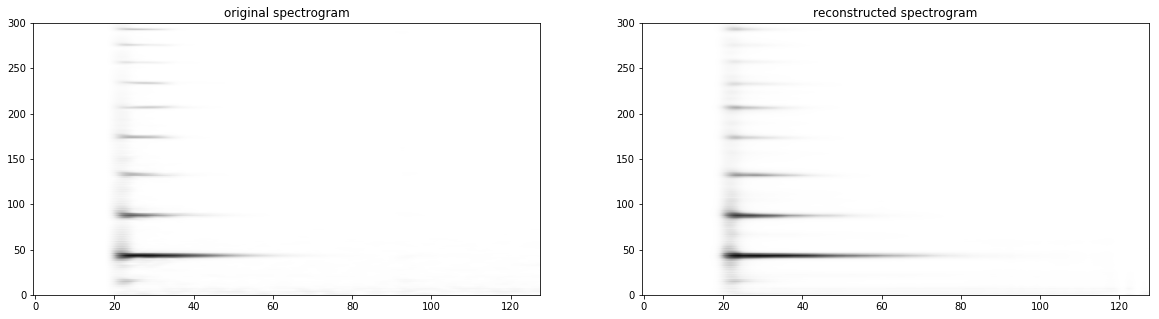

In [11]:
data, o, s = motu[1]

rec  = model(data.unsqueeze(0), o.unsqueeze(0), s.unsqueeze(0))

plt.figure(figsize=(20,5))

plt.subplot(121)
plt.imshow(data.cpu().detach().numpy(), origin="lower", aspect="auto", cmap="Greys", interpolation="bicubic")
plt.ylim([0,300])
plt.title("original spectrogram")

plt.subplot(122)
plt.imshow(rec[0].squeeze(0).cpu().detach().numpy(), origin="lower", aspect="auto", cmap="Greys", interpolation="bicubic")
plt.ylim([0,300])
plt.title("reconstructed spectrogram")

plt.savefig("specto_compa.png")
plt.show()